### LITTLE EYES V3
#### Meu Terceiro Modelo de Visão Computacional

Validação cruzada / controle de parada para selecionar o modelo mais genérico 

In [1]:
# NETWORK
the_seed = 32
digit_size = (28, 28, 1)
convnn_activation = 'relu'
fully_connected_activation = 'tanh'
hyperparameter_max = 5
learning_rate = 0.01
max_epochs = 5
score_metric = 'accuracy'
verbose = 0

# VALIDATION
n_folds = 5

In [2]:
import tensorflow
import keras
from keras import datasets, layers, optimizers, Input, Model
from matplotlib import pyplot
import numpy
import pandas
import random
from sklearn.model_selection import StratifiedKFold
from seaborn import boxplot
from sklearn.metrics import accuracy_score

In [3]:
random.seed(the_seed)
numpy.random.seed(the_seed)
tensorflow.random.set_seed(the_seed)

In [4]:
def create_little_eyes(digit_size : tuple[int, int, int] = (28, 28, 1),
                       convnn_activation : str = 'relu',
                       fully_connected_activation : str = 'tanh',
                       net_name : str = 'LittleEyes',
                       hyperparameter : int = 1):
    # CAMADA DE ENTRADA
    inputs = Input(shape=digit_size)

    # PRIMEIRA CAMADA CONVOLUCIONAL
    conv_2d_layer_1 = layers.Conv2D(2*hyperparameter, (3, 3), activation=convnn_activation)
    x = conv_2d_layer_1(inputs)

    # PRIMEIRA CAMADA MAX POOLING
    maxpool_1 = layers.MaxPooling2D((2, 2))
    x = maxpool_1(x)

    # SEGUNDA CAMADA CONVOLUCIONAL
    conv_2d_layer_2 = layers.Conv2D(4*hyperparameter, (3, 3), activation=convnn_activation)
    x = conv_2d_layer_2(x)

    # SEGUNDA CAMADA MAX POOLING
    maxpool_2 = layers.MaxPooling2D((2, 2))
    x = maxpool_2(x)

    # TERCEIRA CAMADA CONVOLUCIONAL
    conv_2d_layer_3 = layers.Conv2D(4*hyperparameter, (3, 3), activation=convnn_activation)
    x = conv_2d_layer_3(x)

    # TERCEIRA CAMADA MAX POOLING
    maxpool_3 = layers.MaxPooling2D((2, 2))
    x = maxpool_3(x)

    # FLATTEN
    flatten_layer = layers.Flatten()
    x = flatten_layer(x)

    # FULLY CONNECTED HIDDEN LAYER
    hidden_layer = layers.Dense(hyperparameter + 1, activation=fully_connected_activation)
    x = hidden_layer(x)

    # OUTPUT LAYER
    output_layer = layers.Dense(10)
    outputs = output_layer(x)

    return Model(inputs=inputs, outputs=outputs, name=net_name)

In [5]:
(train_images, train_labels), (validation_images, validation_labels) = datasets.mnist.load_data()

# Normalize pixel values to be between 0 and 1
train_images, validation_images = train_images / 255.0, validation_images / 255.0

In [6]:
train_images.shape, validation_images.shape

((60000, 28, 28), (10000, 28, 28))

In [7]:
numpy.unique(train_labels, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949],
       dtype=int64))

In [8]:
result_list = []
kfolder = StratifiedKFold(n_splits=n_folds, random_state=the_seed, shuffle=True)
for hyperparameter in numpy.arange(1, hyperparameter_max+1):
    for i, (train_index, validation_index) in enumerate(kfolder.split(train_images, train_labels)):
        X_train, Y_train = train_images[train_index], train_labels[train_index]
        X_val, Y_val = train_images[validation_index], train_labels[validation_index]

        # NET NAME > Hyperparameter + Fold Number
        net_name = f"LittleEyes_{hyperparameter}_{i}"
        little_eyes = create_little_eyes(net_name = net_name,
                                        hyperparameter=hyperparameter)
        opt = optimizers.Adam(learning_rate=learning_rate)
        little_eyes.compile(optimizer=opt,
                    loss= keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=[score_metric])

        history = little_eyes.fit(X_train, Y_train, epochs=max_epochs, 
                                validation_data=(X_val, Y_val),
                                verbose=verbose)

        training_score = history.history[score_metric][-1]
        validation_score = history.history[f"val_{score_metric}"][-1]
        result_list.append((net_name, hyperparameter, i, training_score, validation_score, little_eyes))
        print(f"{net_name.upper()}: {100*training_score:.0f}% TRAINING {score_metric.upper()} / {100*validation_score:.0f}% VALIDATION {score_metric.upper()}")
        

LITTLEEYES_1_0: 66% TRAINING ACCURACY / 65% VALIDATION ACCURACY
LITTLEEYES_1_1: 73% TRAINING ACCURACY / 74% VALIDATION ACCURACY
LITTLEEYES_1_2: 66% TRAINING ACCURACY / 68% VALIDATION ACCURACY
LITTLEEYES_1_3: 66% TRAINING ACCURACY / 67% VALIDATION ACCURACY
LITTLEEYES_1_4: 67% TRAINING ACCURACY / 66% VALIDATION ACCURACY
LITTLEEYES_2_0: 90% TRAINING ACCURACY / 91% VALIDATION ACCURACY
LITTLEEYES_2_1: 88% TRAINING ACCURACY / 87% VALIDATION ACCURACY
LITTLEEYES_2_2: 84% TRAINING ACCURACY / 85% VALIDATION ACCURACY
LITTLEEYES_2_3: 90% TRAINING ACCURACY / 90% VALIDATION ACCURACY
LITTLEEYES_2_4: 90% TRAINING ACCURACY / 90% VALIDATION ACCURACY
LITTLEEYES_3_0: 93% TRAINING ACCURACY / 93% VALIDATION ACCURACY
LITTLEEYES_3_1: 93% TRAINING ACCURACY / 92% VALIDATION ACCURACY
LITTLEEYES_3_2: 94% TRAINING ACCURACY / 95% VALIDATION ACCURACY
LITTLEEYES_3_3: 93% TRAINING ACCURACY / 92% VALIDATION ACCURACY
LITTLEEYES_3_4: 94% TRAINING ACCURACY / 94% VALIDATION ACCURACY
LITTLEEYES_4_0: 95% TRAINING ACCURACY / 

In [9]:
results = pandas.DataFrame.from_records(result_list)
results.columns = ["net_name", "hyperparameter", "kfold", score_metric, f"val_{score_metric}", "little_eyes"]
results.sort_values("val_accuracy", ascending=False)

,net_name,hyperparameter,kfold,accuracy,val_accuracy,little_eyes
19,LittleEyes_4_4,4,4,0.950542,0.957333,"<Functional name=LittleEyes_4_4, built=True>"
24,LittleEyes_5_4,5,4,0.952729,0.954583,"<Functional name=LittleEyes_5_4, built=True>"
15,LittleEyes_4_0,4,0,0.953104,0.953000,"<Functional name=LittleEyes_4_0, built=True>"
20,LittleEyes_5_0,5,0,0.952896,0.950833,"<Functional name=LittleEyes_5_0, built=True>"
17,LittleEyes_4_2,4,2,0.954125,0.949500,"<Functional name=LittleEyes_4_2, built=True>"
23,LittleEyes_5_3,5,3,0.956521,0.947917,"<Functional name=LittleEyes_5_3, built=True>"
12,LittleEyes_3_2,3,2,0.943479,0.947917,"<Functional name=LittleEyes_3_2, built=True>"
16,LittleEyes_4_1,4,1,0.954562,0.947250,"<Functional name=LittleEyes_4_1, built=True>"
18,LittleEyes_4_3,4,3,0.948542,0.945833,"<Functional name=LittleEyes_4_3, built=True>"
21,LittleEyes_5_1,5,1,0.952542,0.945000,"<Functional name=LittleEyes_5_1, built=True>"


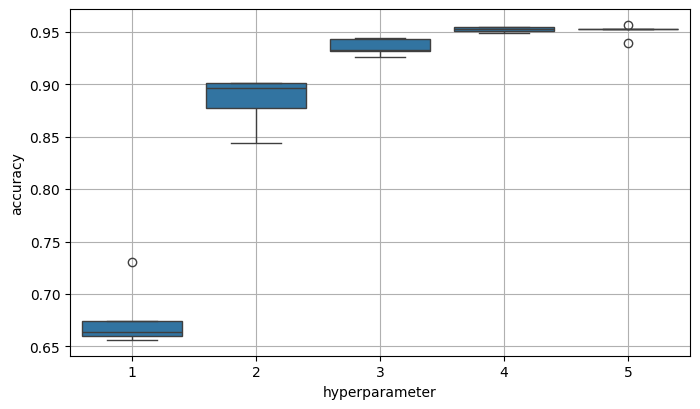

In [10]:
fig = pyplot.figure(figsize=(8, 4.5))
ax = fig.add_subplot(111)
boxplot(results, x="hyperparameter", y="accuracy", ax=ax)
ax.grid()

In [11]:
little_eyes = results.sort_values('val_accuracy', ascending=False).head(1)['little_eyes'].values[0]
little_eyes

<Functional name=LittleEyes_4_4, built=True>

In [12]:
Y_test = little_eyes.predict(validation_images)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [13]:
Y_predicted = numpy.argmax(Y_test, axis=1)
Y_predicted

array([7, 2, 1, ..., 4, 5, 6], dtype=int64)

In [14]:
# find where the predicted labels are different from the true labels
wrong_index = numpy.where(Y_predicted != validation_labels)[0]
wrong_index

array([  33,   77,   97,  149,  175,  184,  242,  247,  257,  282,  307,
        321,  324,  326,  333,  362,  380,  381,  420,  449,  450,  468,
        516,  527,  550,  551,  571,  582,  611,  619,  646,  659,  684,
        717,  723,  726,  740,  882,  883,  898,  926,  932,  936,  938,
        947,  950,  956,  957,  969,  982, 1026, 1032, 1039, 1068, 1114,
       1119, 1124, 1128, 1156, 1173, 1181, 1191, 1194, 1204, 1226, 1232,
       1239, 1247, 1256, 1260, 1283, 1290, 1299, 1326, 1328, 1337, 1365,
       1402, 1436, 1459, 1463, 1500, 1522, 1527, 1553, 1556, 1581, 1618,
       1621, 1641, 1678, 1681, 1682, 1696, 1709, 1716, 1718, 1721, 1722,
       1727, 1751, 1754, 1782, 1790, 1816, 1847, 1878, 1930, 1938, 1940,
       1941, 1987, 2016, 2018, 2035, 2040, 2043, 2063, 2070, 2090, 2105,
       2109, 2130, 2145, 2153, 2182, 2185, 2189, 2198, 2225, 2280, 2293,
       2298, 2308, 2318, 2358, 2370, 2380, 2394, 2395, 2405, 2406, 2414,
       2447, 2454, 2455, 2462, 2488, 2534, 2539, 25

In [19]:
wrong_index.shape[0]

413

TRUE NUMBER 7 >> PREDICTED NUMBER 9


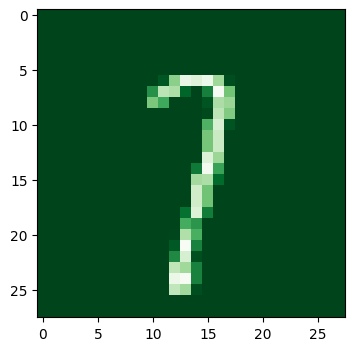

In [29]:
# TABAJARA VALIDATOR
image_id = 175
print(f"TRUE NUMBER {validation_labels[image_id]} >> PREDICTED NUMBER {Y_predicted[image_id]}")
# Y_test[image_id, :]
fig = pyplot.figure(figsize=(4, 4))
ax = fig.add_subplot(111)
_ = pyplot.imshow(validation_images[image_id], cmap="Greens_r")

In [16]:
accuracy_score(validation_labels, Y_predicted)

0.9587